In [1]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../modules')
from nsw.nsw_classifier import NSWClassifier
import nsw.data_gen as dg

In [2]:
import time

def analyze_classifier(classifier, test, label, iterations=7):
    path_times, knn_times = [], []
    path, knn = 0, 0
    times = iterations

    for i in range(times):
        print(f"iteration {i}")
        s = time.perf_counter()
        for t in test:
            path += classifier.classify_by_path(t[0], attempts=1) == t[1]
        f = time.perf_counter()
        path_times.append(1000 * (f - s) / len(test))
        print(f"path {path}, time {f-s:.3f}")
        
        s = time.perf_counter()
        for t in test:
            knn += classifier.classify_knn(t[0], attempts=1) == t[1]
        f = time.perf_counter()
        knn_times.append(1000 * (f - s) / len(test))
        print(f"1-nn {knn}, time {f-s:.3f}")


    print(f"{label}: PATH classifier accuracy = {100 * path / len(test) / times:.2f}%")
    print(f"{label}: 1-NN classifier accuracy = {100 * knn / len(test) / times:.2f}%")

    plt.xlabel("iteration #", fontsize=14)
    plt.ylabel("avg time, ms", fontsize=14)
    plt.plot(range(len(path_times)), path_times, 'k--', label="PATH")
    plt.plot(range(len(knn_times)), knn_times, 'k-', label="1-KNN")
    plt.xticks(range(0, len(knn_times)+1, 5))
    plt.legend()
    plt.show()


    speedup = [a / b for a, b in zip(knn_times, path_times)]
    plt.plot(range(len(speedup)), speedup, 'k-', label="speedup (times)")
    plt.xticks(range(0, len(speedup)+1, 5))
    plt.legend()
    plt.xlabel("iteration #", fontsize=14)
    plt.ylabel("speedup", fontsize=14)

    plt.show()

    print(f"Speedup: Min = {min(speedup):.2f}, Max = {max(speedup):.2f}, Avg = {sum(speedup) / len(speedup):.2f}")

# 1. Synthetic dataset - no noise - proof of concept

Classifier graph is build in 11.141s


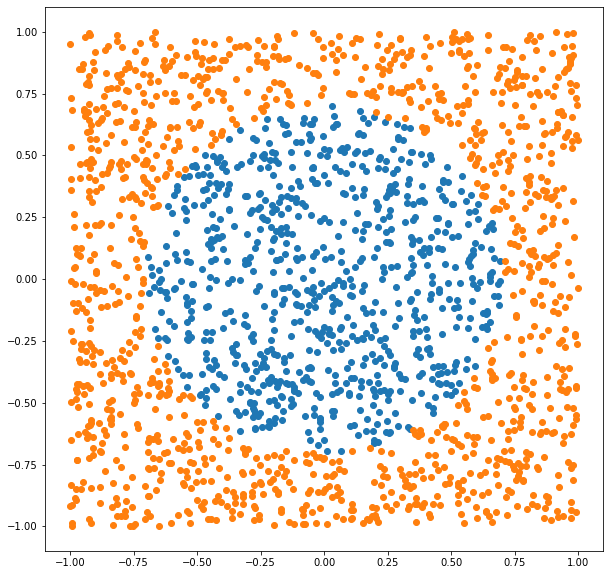

In [3]:
classifier = NSWClassifier()
data = dg.gen(N=2000, border=0.7)
classifier.build_navigable_graph(data, attempts=20)

# show classes
cls0 = np.array([r[0] for r in data if r[1] == 0])
cls1 = np.array([r[0] for r in data if r[1] == 1])
plt.figure(figsize=(10, 10))
plt.scatter(cls0[:,0], cls0[:,1])
plt.scatter(cls1[:,0], cls1[:,1])
plt.show()

iteration 0
path 199, time 0.815
1-nn 197, time 0.913
iteration 1
path 398, time 0.574
1-nn 394, time 0.987
iteration 2
path 595, time 0.736
1-nn 591, time 0.965
iteration 3
path 793, time 0.624
1-nn 788, time 0.849
iteration 4
path 992, time 0.724
1-nn 985, time 0.807
iteration 5
path 1191, time 0.708
1-nn 1182, time 0.865
iteration 6
path 1388, time 0.610
1-nn 1379, time 0.925
iteration 7
path 1587, time 0.680
1-nn 1576, time 0.944
iteration 8
path 1785, time 0.755
1-nn 1773, time 0.995
iteration 9
path 1983, time 0.778
1-nn 1970, time 0.976
iteration 10
path 2177, time 0.727
1-nn 2167, time 0.971
iteration 11
path 2375, time 0.714
1-nn 2364, time 1.279
iteration 12
path 2573, time 1.013
1-nn 2561, time 1.247
iteration 13
path 2770, time 0.864
1-nn 2758, time 1.014
iteration 14
path 2967, time 0.934
1-nn 2955, time 1.364
iteration 15
path 3164, time 0.911
1-nn 3152, time 1.083
iteration 16
path 3358, time 0.847
1-nn 3349, time 1.257
iteration 17
path 3554, time 0.860
1-nn 3546, time 

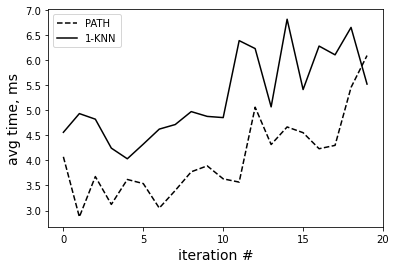

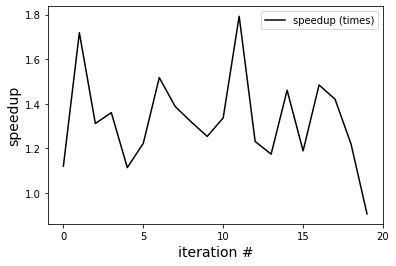

Speedup: Min = 0.91, Max = 1.79, Avg = 1.33


In [4]:
test = dg.gen(N=200, border=0.7)
analyze_classifier(classifier, test, "Synth", iterations=20)

In [5]:
classifier = NSWClassifier()
data = dg.gen(N=5000, border=0.7)
classifier.build_navigable_graph(data, attempts=10)
test = dg.gen(N=400, border=0.7)

Classifier graph is build in 39.186s


iteration 0
path 384, time 2.396
1-nn 396, time 3.561
iteration 1
path 772, time 2.846
1-nn 792, time 3.495
iteration 2
path 1154, time 2.118
1-nn 1188, time 2.433
iteration 3
path 1542, time 1.797
1-nn 1584, time 2.469
iteration 4
path 1929, time 2.071
1-nn 1980, time 2.341
iteration 5
path 2317, time 1.679
1-nn 2376, time 2.336
iteration 6
path 2704, time 1.647
1-nn 2772, time 2.403
iteration 7
path 3089, time 1.774
1-nn 3168, time 2.605
iteration 8
path 3476, time 2.111
1-nn 3565, time 2.362
iteration 9
path 3861, time 1.909
1-nn 3962, time 2.391
iteration 10
path 4247, time 1.738
1-nn 4358, time 2.529
iteration 11
path 4630, time 1.851
1-nn 4754, time 2.579
iteration 12
path 5019, time 1.583
1-nn 5151, time 2.367
iteration 13
path 5404, time 1.641
1-nn 5547, time 2.258
iteration 14
path 5793, time 1.599
1-nn 5944, time 2.400
iteration 15
path 6178, time 1.734
1-nn 6341, time 2.539
iteration 16
path 6564, time 1.683
1-nn 6737, time 2.286
iteration 17
path 6952, time 1.774
1-nn 7133,

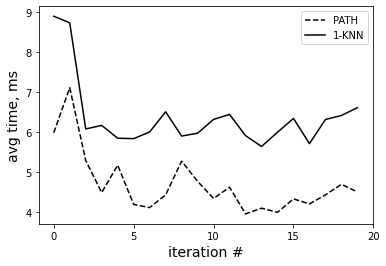

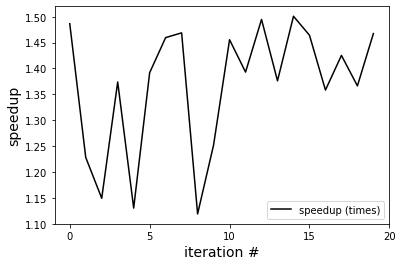

Speedup: Min = 1.12, Max = 1.50, Avg = 1.37


In [6]:
analyze_classifier(classifier, test, "Synth", iterations=20)

!! NB: speedup does not depend on dataset size

Classifier graph is build in 24.854s
Analyzing 4 case
iteration 0
path 173, time 1.037
1-nn 184, time 1.661
iteration 1
path 344, time 1.134
1-nn 368, time 1.925
iteration 2
path 518, time 1.054
1-nn 552, time 1.580
iteration 3
path 693, time 0.987
1-nn 736, time 1.754
iteration 4
path 866, time 1.246
1-nn 920, time 1.841
iteration 5
path 1039, time 1.166
1-nn 1104, time 1.797
iteration 6
path 1213, time 1.036
1-nn 1288, time 2.318
iteration 7
path 1387, time 1.354
1-nn 1472, time 2.265
iteration 8
path 1560, time 1.201
1-nn 1656, time 1.809
iteration 9
path 1733, time 1.056
1-nn 1840, time 1.733
Synth: PATH classifier accuracy = 86.65%
Synth: 1-NN classifier accuracy = 92.00%


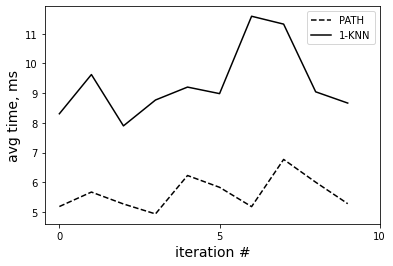

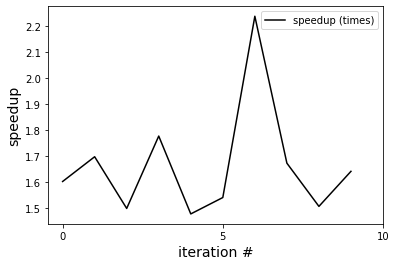

Speedup: Min = 1.48, Max = 2.24, Avg = 1.67
Classifier graph is build in 148.720s
Analyzing 16 case
iteration 0
path 115, time 3.148
1-nn 110, time 8.856
iteration 1
path 232, time 2.841
1-nn 220, time 8.711
iteration 2
path 351, time 3.480
1-nn 330, time 8.614
iteration 3
path 469, time 3.064
1-nn 440, time 8.315
iteration 4
path 587, time 3.156
1-nn 550, time 8.061
iteration 5
path 701, time 2.976
1-nn 660, time 8.443
iteration 6
path 812, time 2.991
1-nn 770, time 8.300
iteration 7
path 929, time 3.238
1-nn 880, time 8.810
iteration 8
path 1044, time 3.105
1-nn 990, time 9.081
iteration 9
path 1161, time 3.203
1-nn 1100, time 8.843
Synth: PATH classifier accuracy = 58.05%
Synth: 1-NN classifier accuracy = 55.00%


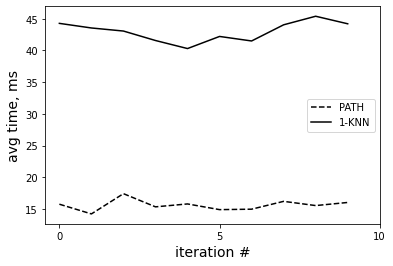

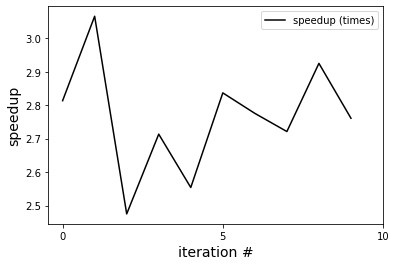

Speedup: Min = 2.47, Max = 3.07, Avg = 2.76
Classifier graph is build in 329.481s
Analyzing 64 case
iteration 0
path 86, time 9.730
1-nn 85, time 17.841
iteration 1
path 169, time 7.470
1-nn 170, time 18.692
iteration 2
path 255, time 7.847
1-nn 255, time 21.235
iteration 3
path 342, time 6.240
1-nn 340, time 17.836
iteration 4
path 429, time 6.457
1-nn 425, time 18.521
iteration 5
path 515, time 6.953
1-nn 510, time 25.125
iteration 6
path 602, time 9.351
1-nn 595, time 25.343
iteration 7
path 688, time 9.711
1-nn 680, time 25.407
iteration 8
path 773, time 9.722
1-nn 765, time 25.772
iteration 9
path 857, time 9.815
1-nn 850, time 24.745
Synth: PATH classifier accuracy = 42.85%
Synth: 1-NN classifier accuracy = 42.50%


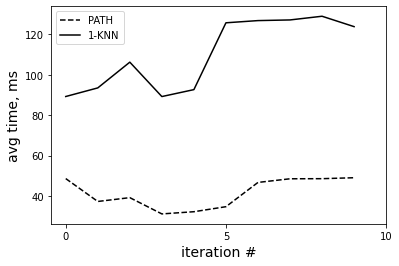

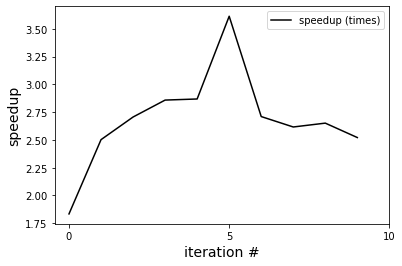

Speedup: Min = 1.83, Max = 3.61, Avg = 2.69
Classifier graph is build in 782.891s
Analyzing 256 case
iteration 0
path 108, time 23.742
1-nn 114, time 25.259
iteration 1
path 212, time 18.184
1-nn 228, time 24.779
iteration 2
path 313, time 16.774
1-nn 342, time 31.820
iteration 3
path 414, time 21.830
1-nn 456, time 28.941
iteration 4
path 518, time 17.408
1-nn 570, time 24.117
iteration 5
path 618, time 18.353
1-nn 684, time 25.027
iteration 6
path 723, time 16.267
1-nn 798, time 24.999
iteration 7
path 826, time 22.592
1-nn 912, time 31.350
iteration 8
path 926, time 17.501
1-nn 1026, time 23.594
iteration 9
path 1032, time 23.208
1-nn 1140, time 33.015
Synth: PATH classifier accuracy = 51.60%
Synth: 1-NN classifier accuracy = 57.00%


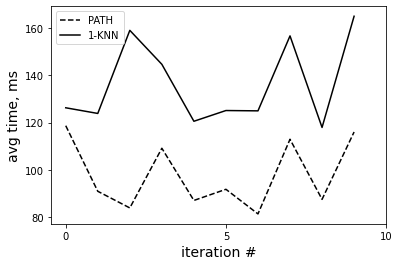

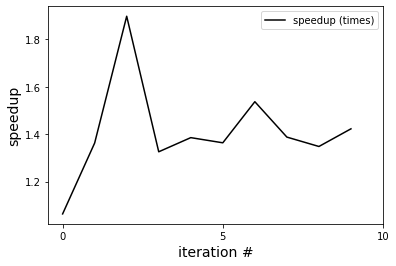

Speedup: Min = 1.06, Max = 1.90, Avg = 1.41


In [7]:
for dim in [4, 16, 64, 256]:
    classifier = NSWClassifier()
    data = dg.gen_kd(N=3000, k=dim, border=0.79 * (dim / 2) ** .5)
    classifier.build_navigable_graph(data, attempts=10)
    test = dg.gen_kd(N=200, k=dim, border=0.79 * (dim / 2) ** .5)
    print(f"Analyzing {dim} case")
    analyze_classifier(classifier, test, "Synth", iterations=10)

# 2. Simple case: MINST

```
@ARTICLE{155943,
  author={L. {Xu} and A. {Krzyzak} and C. Y. {Suen}},
  journal={IEEE Transactions on Systems, Man, and Cybernetics}, 
  title={Methods of combining multiple classifiers and their applications to handwriting recognition}, 
  year={1992},
  volume={22},
  number={3},
  pages={418-435},}
```

In [8]:
from sklearn import datasets
import random

digits = datasets.load_digits()
X, Y = [x.flatten() for x in digits.images], digits.target
XY = list(zip(X, Y))
random.shuffle(XY)
train_mnist, test_mnist = XY[:9 * len(XY) // 10], XY[9 * len(XY) // 10:]

minst_classifier = NSWClassifier()
minst_classifier.build_navigable_graph(train_mnist, attempts=20)

Classifier graph is build in 106.738s


iteration 0
path 179, time 6.216
1-nn 178, time 8.760
iteration 1
path 358, time 6.293
1-nn 356, time 9.222
iteration 2
path 537, time 8.514
1-nn 534, time 16.992
iteration 3
path 716, time 6.810
1-nn 712, time 10.139
iteration 4
path 895, time 6.246
1-nn 890, time 9.149
iteration 5
path 1074, time 7.386
1-nn 1068, time 9.830
iteration 6
path 1253, time 6.105
1-nn 1246, time 9.018
iteration 7
path 1432, time 7.829
1-nn 1424, time 10.371
iteration 8
path 1611, time 6.272
1-nn 1602, time 8.889
iteration 9
path 1790, time 6.449
1-nn 1780, time 8.871
MNIST: PATH classifier accuracy = 99.44%
MNIST: 1-NN classifier accuracy = 98.89%


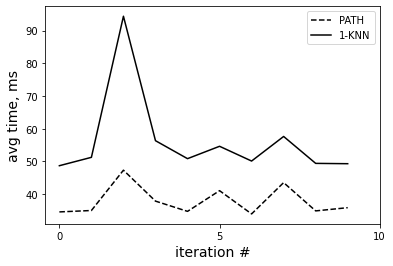

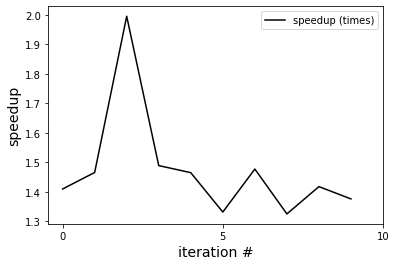

Speedup: Min = 1.32, Max = 2.00, Avg = 1.47


In [9]:
analyze_classifier(minst_classifier, test_mnist, 'MNIST', iterations=10)

# 100 leaves

[dataset](https://archive.ics.uci.edu/ml/datasets/One-hundred+plant+species+leaves+data+set)

```
@inproceedings{Mallah2013PLANTLC,
  title={PLANT LEAF CLASSIFICATION USING PROBABILISTIC INTEGRATION OF SHAPE, TEXTURE AND MARGIN FEATURES},
  author={Charles D. Mallah and James S. Cope and James Orwell},
  year={2013}
}
```

In [10]:
import random

texture_file = "../data/100leaves/data_Tex_64.txt"
shape_file = "../data/100leaves/data_Sha_64.txt"
margin_file = "../data/100leaves/data_Mar_64.txt"

dataset1, dataset2, dataset3 = [], [], []
for line1, line2, line3 in zip(open(texture_file), open(shape_file), open(margin_file)):
    parts = line1.strip().split(',')
    class_, vect = parts[0], list(map(float, parts[1:]))
    dataset1.append((vect, class_))
    
    parts = line2.strip().split(',')
    class_, vect = parts[0], list(map(float, parts[1:]))
    dataset2.append((vect, class_))
    
    parts = line3.strip().split(',')
    class_, vect = parts[0], list(map(float, parts[1:]))
    dataset3.append((vect, class_))

random.shuffle(dataset1)
random.shuffle(dataset2)
random.shuffle(dataset3)

train 1439; test 160
Classifier graph is build in 94.855s
iteration 0
path 120, time 9.037
1-nn 65, time 10.008
iteration 1
path 240, time 8.990
1-nn 130, time 10.966
iteration 2
path 360, time 7.684
1-nn 195, time 7.589
iteration 3
path 480, time 7.308
1-nn 260, time 8.127
iteration 4
path 600, time 6.947
1-nn 325, time 7.834
iteration 5
path 720, time 6.508
1-nn 390, time 8.170
iteration 6
path 840, time 6.688
1-nn 455, time 8.251
iteration 7
path 960, time 7.842
1-nn 520, time 7.597
iteration 8
path 1080, time 6.562
1-nn 585, time 7.362
iteration 9
path 1200, time 6.114
1-nn 650, time 7.527
100LEAVES: PATH classifier accuracy = 75.00%
100LEAVES: 1-NN classifier accuracy = 40.62%


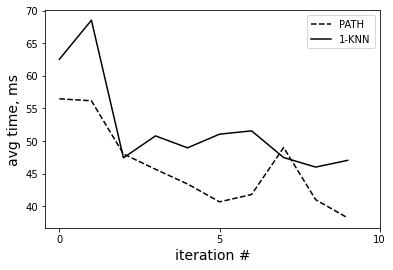

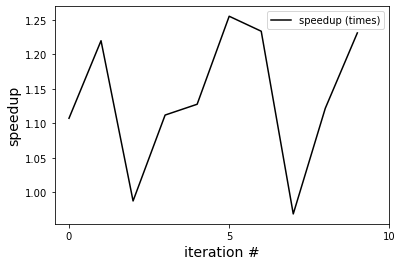

Speedup: Min = 0.97, Max = 1.26, Avg = 1.14
train 1439; test 160
Classifier graph is build in 61.356s
iteration 0
path 103, time 7.139
1-nn 48, time 7.862
iteration 1
path 206, time 6.056
1-nn 96, time 6.503
iteration 2
path 309, time 6.766
1-nn 144, time 6.431
iteration 3
path 412, time 6.494
1-nn 192, time 6.214
iteration 4
path 515, time 6.222
1-nn 240, time 6.637
iteration 5
path 618, time 6.024
1-nn 288, time 6.592
iteration 6
path 721, time 6.525
1-nn 336, time 6.637
iteration 7
path 824, time 6.408
1-nn 384, time 6.465
iteration 8
path 927, time 6.476
1-nn 432, time 6.507
iteration 9
path 1030, time 6.243
1-nn 480, time 6.607
100LEAVES: PATH classifier accuracy = 64.38%
100LEAVES: 1-NN classifier accuracy = 30.00%


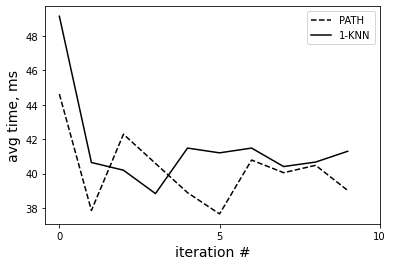

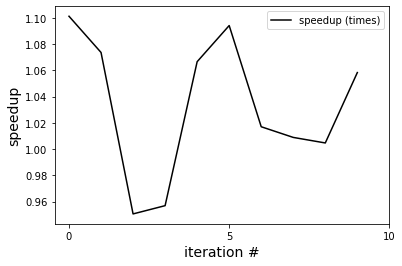

Speedup: Min = 0.95, Max = 1.10, Avg = 1.03
train 1439; test 160
Classifier graph is build in 65.481s
iteration 0
path 109, time 6.242
1-nn 83, time 7.219
iteration 1
path 218, time 6.209
1-nn 166, time 7.052
iteration 2
path 327, time 5.877
1-nn 249, time 6.682
iteration 3
path 436, time 6.300
1-nn 332, time 6.709
iteration 4
path 545, time 6.244
1-nn 415, time 6.739
iteration 5
path 654, time 6.157
1-nn 498, time 7.279
iteration 6
path 763, time 6.266
1-nn 581, time 7.232
iteration 7
path 872, time 6.170
1-nn 664, time 8.212
iteration 8
path 981, time 6.958
1-nn 747, time 8.714
iteration 9
path 1090, time 6.892
1-nn 830, time 7.006
100LEAVES: PATH classifier accuracy = 68.12%
100LEAVES: 1-NN classifier accuracy = 51.88%


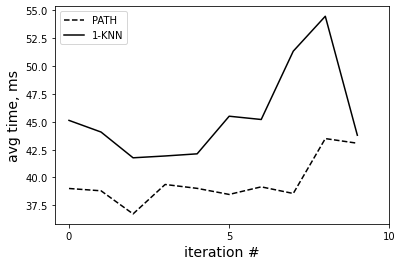

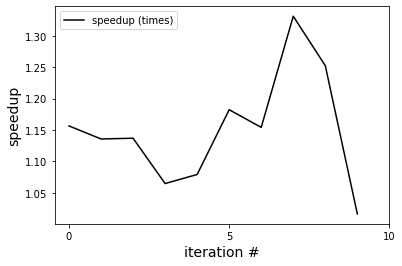

Speedup: Min = 1.02, Max = 1.33, Avg = 1.15


In [11]:
for dataset in [dataset1, dataset2, dataset3]:
    train_leaves, test_leaves = dataset[:9 * len(dataset) // 10], dataset[9 * len(dataset) // 10:]
    print(f"train {len(train_leaves)}; test {len(test_leaves)}")

    leaves_classifier = NSWClassifier()
    leaves_classifier.build_navigable_graph(train_leaves, attempts=10)
    analyze_classifier(leaves_classifier, test_leaves, "100LEAVES", iterations=10)

## 1024 dim data
Download `data8.pickle` from https://www.kaggle.com/valentynsichkar/traffic-signs-preprocessed

In [12]:
import pickle

with open('../data/data8.pickle', 'rb') as f:
    data = pickle.load(f)

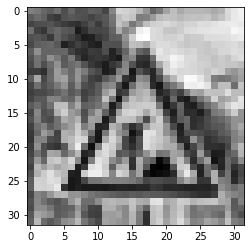

In [13]:
x_train = data['x_train']
x_train = x_train.reshape((86989, -1))
y_train = data['y_train']

x_train, y_train = x_train[:10000, :], y_train[:10000]

x_test = data['x_test']
x_test = x_test.reshape((12630, -1))
y_test = data['y_test']

x_test, y_test = x_test[:500, :], y_test[:500]

plt.imshow(x_test[0].reshape(32, 32), cmap="gray")
plt.show()

In [14]:
import cv2
dataset = list(zip(x_train, y_train))
dataset_small = []
for r in dataset:
    r2 = cv2.resize(r[0].reshape((32, 32)), (16, 16)).reshape((-1))
    dataset_small.append((r2, r[1]))

signs_classifier = NSWClassifier()
signs_classifier.build_navigable_graph(dataset_small, attempts=5)

Classifier graph is build in 4589.179s


In [15]:
testset = list(zip(x_test, y_test))[:100]
testset_small = []
for r in testset:
    r2 = cv2.resize(r[0].reshape((32, 32)), (16, 16)).reshape((-1))
    testset_small.append((r2, r[1]))

iteration 0
path 37, time 13.941
1-nn 18, time 23.784
iteration 1
path 75, time 12.949
1-nn 36, time 23.694
iteration 2
path 112, time 12.990
1-nn 54, time 23.520
iteration 3
path 150, time 14.100
1-nn 72, time 23.733
iteration 4
path 188, time 13.108
1-nn 90, time 25.109
iteration 5
path 226, time 16.280
1-nn 108, time 51.887
iteration 6
path 262, time 13.145
1-nn 126, time 23.966
iteration 7
path 300, time 14.049
1-nn 144, time 24.083
iteration 8
path 338, time 13.212
1-nn 162, time 24.280
iteration 9
path 375, time 13.992
1-nn 180, time 24.513
signs: PATH classifier accuracy = 37.50%
signs: 1-NN classifier accuracy = 18.00%


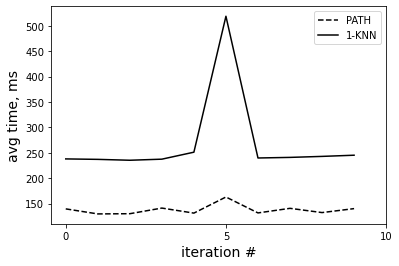

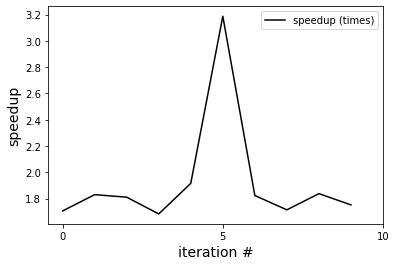

Speedup: Min = 1.68, Max = 3.19, Avg = 1.93


In [16]:
analyze_classifier(signs_classifier, testset_small, "signs", iterations=10)